In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tqdm as tqdm

2025-10-02 11:38:35.958166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759405116.160016      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759405116.221549      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tqdm import tqdm
import os
import numpy as np
import cv2

def load_data(image_path, mask_path, img_size=(256, 256)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_path))
    mask_files = sorted(os.listdir(mask_path))

    for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Loading Data"):
        new_image_path = os.path.join(image_path, image_file)
        new_mask_path = os.path.join(mask_path, mask_file)

        image = cv2.imread(new_image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(new_mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Warning: Could not load image {image_file}")
            continue
        if mask is None:
            print(f"Warning: Could not load mask {mask_file}")
            continue

        image = cv2.resize(image, img_size) / 255.0 
        mask = cv2.resize(mask, img_size) / 255.0
        kernel = np.ones((3, 3), np.uint8)

        eroded_mask = cv2.erode(mask, kernel, iterations=1)
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
        
        final_mask = dilated_mask # Or eroded_mask, or the original mask
        mask = np.expand_dims(final_mask, axis=-1)

        images.append(image)
        masks.append(mask)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)


In [3]:
def conv_block(inputs , num_filters) :
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

In [4]:
def unet_3_plus(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    x00 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D(2)(x00)

    x10 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D(2)(x10)

    x20 = conv_block(p2, 64) 
    p3 = layers.MaxPooling2D(2)(x20)

    x30 = conv_block(p3, 128)
    p4 = layers.MaxPooling2D(2)(x30)

    x40 = conv_block(p4, 256)

    y40 = layers.Conv2DTranspose(128, 2, 2, padding="same")(x40)
    y20 = layers.MaxPooling2D(2)(x20)
    y20 = layers.Conv2D(128, (3,3), padding="same")(y20)
    y10 = layers.MaxPooling2D(4)(x10)
    y10 = layers.Conv2D(128, (3,3), padding="same")(y10)
    y00 = layers.MaxPooling2D(8)(x00)
    y00 = layers.Conv2D(128, (3,3), padding="same")(y00)
    x31 = layers.concatenate([y40, y20, y10, y00 , x30])
    x31 = conv_block(x31, 128)

    y31 = layers.Conv2DTranspose(64, 2, 2, padding="same")(x31)
    y40 = layers.Conv2DTranspose(64, 2, 4, padding="same")(x40)
    y10 = layers.MaxPooling2D(2)(x10)
    y10 = layers.Conv2D(64, (3,3), padding="same")(y10)
    y00 = layers.MaxPooling2D(4)(x00)   
    y00 = layers.Conv2D(64, (3,3), padding="same")(y00)
    x22 = layers.concatenate([y40, y10, y00, x20, y31])
    x22 = conv_block(x22, 64)

    y22 = layers.Conv2DTranspose(32, 2, 2, padding="same")(x22)
    y40 = layers.Conv2DTranspose(32, 2, 8, padding="same")(x40)
    y31 = layers.Conv2DTranspose(32, 2, 4, padding="same")(x31)
    y00 = layers.MaxPooling2D(2)(x00)
    y00 = layers.Conv2D(32, (3,3), padding="same")(y00)
    x13 = layers.concatenate([y40, y31, y00, x10, y22])
    x13 = conv_block(x13, 32)

    y13 = layers.Conv2DTranspose(16, 2, 2, padding="same")(x13)
    y40 = layers.Conv2DTranspose(16, 2, 16, padding="same")(x40)
    y31 = layers.Conv2DTranspose(16, 2, 8, padding="same")(x31)
    y22 = layers.Conv2DTranspose(16, 2, 4, padding="same")(x22)
    x04 = layers.concatenate([y40, y31, y22, x00, y13])
    x04 = conv_block(x04, 16)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(x04)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = unet_3_plus()
model.summary()


I0000 00:00:1759405128.905777      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 2,839,873 (10.83 MB)

 Trainable params: 2,836,929 (10.82 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [6]:
!ls /kaggle/input
!ls /kaggle/input/new-crack
!ls /kaggle/input/data


new-crack
data
ls: cannot access '/kaggle/input/data': No such file or directory


In [7]:
image_path = '/kaggle/input/new-crack/data/data-crack'
mask_path = '/kaggle/input/new-crack/data/new_mask_folder'

im, ma = load_data(image_path, mask_path)
print("DONE👍")

Loading Data: 100%|██████████| 1130/1130 [01:14<00:00, 15.17it/s]


DONE👍


In [8]:
# X_train, X_temp, Y_train, Y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
X_train, X_temp, Y_train, Y_temp = train_test_split(im, ma, test_size=0.2, random_state=42)

X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 904, Validation: 113, Test: 113


In [9]:
# checkpoints = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')
# ]

# history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=25, callbacks=callbacks, verbose=1)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=20,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
I0000 00:00:1759405292.606626      94 service.cc:148] XLA service 0x7ac9f40d26f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759405292.607330      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759405294.727863      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/57 ━━━━━━━━━━━━━━━━━━━━ 41:11 44s/step - accuracy: 0.6093 - loss: 0.6689

I0000 00:00:1759405314.340864      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 491ms/step - accuracy: 0.9045 - loss: 0.3954 - val_accuracy: 0.9704 - val_loss: 0.4515
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9815 - loss: 0.1755 - val_accuracy: 0.9704 - val_loss: 0.2244
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9841 - loss: 0.1264 - val_accuracy: 0.9707 - val_loss: 0.1508
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9849 - loss: 0.0974 - val_accuracy: 0.9709 - val_loss: 0.1348
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9854 - loss: 0.0809 - val_accuracy: 0.9728 - val_loss: 0.1118
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9860 - loss: 0.0684 - val_accuracy: 0.9786 - val_loss: 0.0852
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9851 - loss: 0.0630 - val_accuracy: 0.9833 - val_loss: 0.0649
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9865 - loss: 0.0544 - val_accuracy: 0.9846 - val

In [10]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.35).astype(np.uint8)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [11]:
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

ious = [iou_score(Y_test[i], Y_pred[i]) for i in range(len(Y_test))]
mean_iou = np.mean(ious)

print(f"Mean IoU Score: {mean_iou:.4f}")


Mean IoU Score: 0.6419


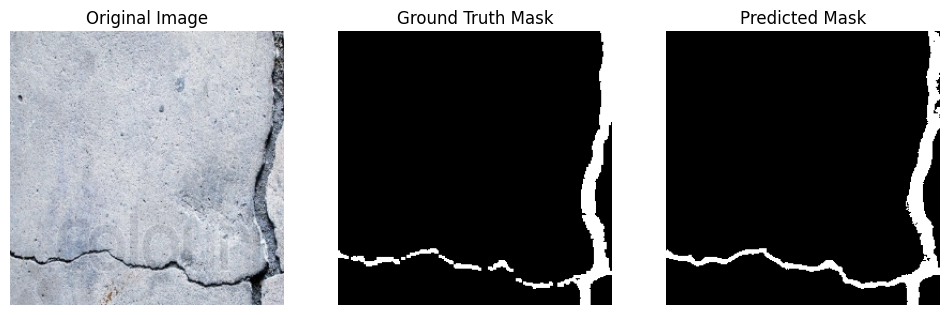

Sample IoU Score: 0.8259


In [18]:
import random

random_index = random.randint(0, len(X_test) - 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_test[random_index])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(Y_test[random_index], cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(Y_pred[random_index], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()

iou_score_sample = iou_score(Y_test[random_index], Y_pred[random_index])
print(f"Sample IoU Score: {iou_score_sample:.4f}")